In [100]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import mne as mne
from scipy import signal 
from mne.preprocessing import ICA 
import ast  
from scipy.signal import argrelextrema 

In [101]:
def load_data(file_name, visualize=False):
    
    df = pd.read_csv(file_name, header=None, skiprows=1)
    df[0] = df[0].apply(ast.literal_eval)
    return df

In [102]:
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [103]:
def process_data(df, fs, lowcut, highcut):
    processed_data = pd.DataFrame()
    for i in range(4):  # Assuming four electrodes
        electrode_data = [item[i] for item in df[0]]
        processed_data[f'Electrode {i+1}'] = apply_bandpass_filter(electrode_data, lowcut, highcut, fs)
    return processed_data

In [104]:
def plot_session(data, title, is_processed=False):
    plt.figure(figsize=(12, 6))
    if is_processed:
        for column in data.columns:
            plt.plot(data[column][:510], label=column)
    else:
        for i in range(4):
            plt.plot([item[i] for item in data[0][:510]], label=f'Electrode {i+1}')
    plt.title(title)
    plt.xlabel('Time Points')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [105]:
def extract_features(data, session_length, fs):
    n_sessions = data.shape[0] // session_length
    features = []

    for i in range(n_sessions):
        session_data = data.iloc[i * session_length:(i + 1) * session_length]
        session_features = []

        for j in range(session_data.shape[1]):
            electrode_data = session_data.iloc[:, j]

            # Calcolo della differenza di tempo tra il minimo e il massimo
            time_max = electrode_data.idxmax() / fs
            time_min = electrode_data.idxmin() / fs
            time_diff = abs(time_max - time_min)

            # Calcolo della differenza di ampiezza
            amplitude_diff = electrode_data.max() - electrode_data.min()

            session_features.extend([time_diff, amplitude_diff])

        features.append(session_features)

    return np.array(features)


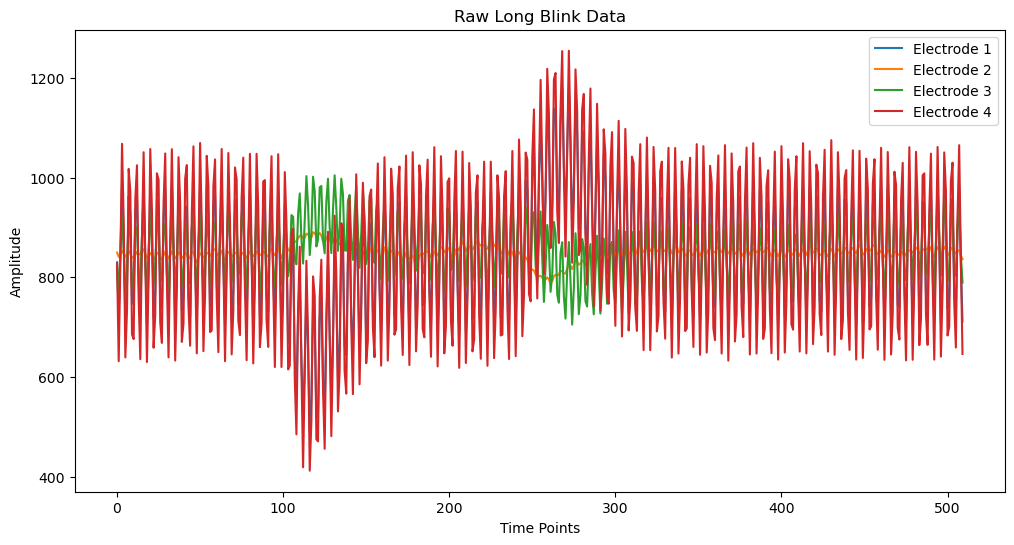

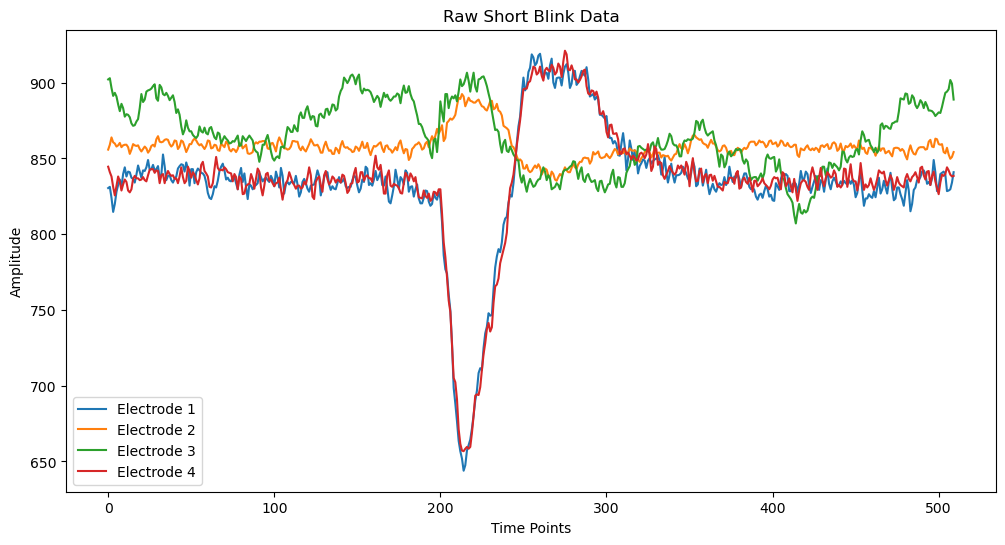

In [106]:
fs = 215  # Frequenza di campionamento
lowcut, highcut = 1.0, 30.0  # Frequenze di taglio per il filtro
long_blink = load_data('LongBlink.csv')
short_blink = load_data('ShortBlink.csv')

plot_session(long_blink, 'Raw Long Blink Data',is_processed=False )
plot_session(short_blink,'Raw Short Blink Data',is_processed=False )

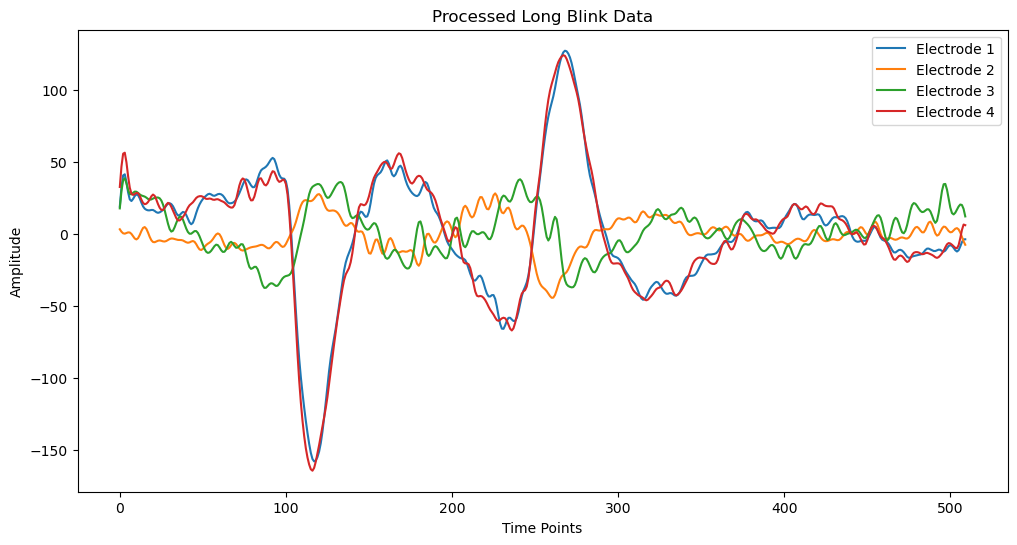

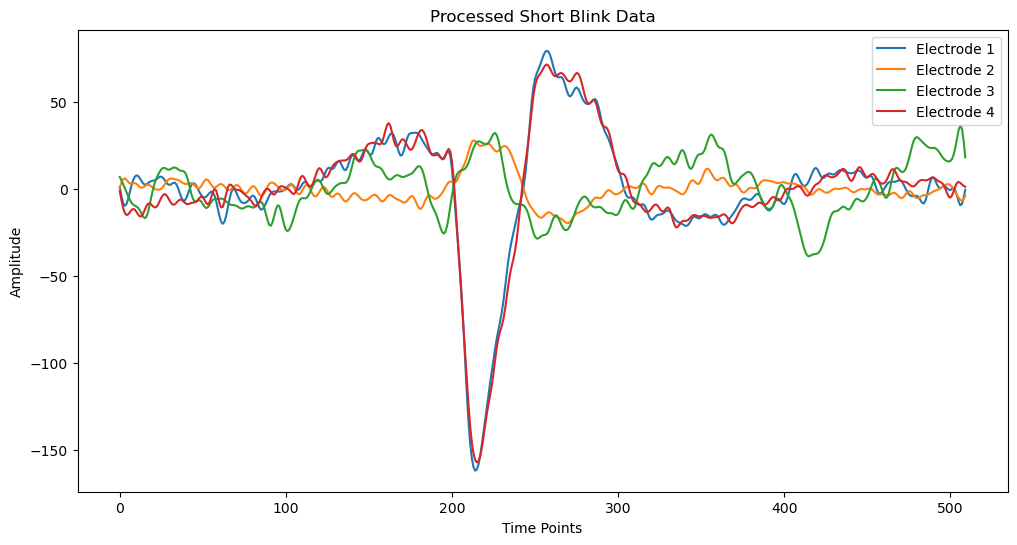

In [107]:
# Filtrare e visualizzare i dati per ogni sessione
filtered_long_blink = process_data(long_blink, fs, lowcut, highcut)
filtered_short_blink = process_data(short_blink, fs, lowcut, highcut)

plot_session(filtered_long_blink, 'Processed Long Blink Data',fs)
plot_session(filtered_short_blink,'Processed Short Blink Data',fs)

In [155]:
# Assumendo che filtered_long_blink e filtered_short_blink siano i dati filtrati
features_long_blink = extract_features(filtered_long_blink, 510, fs)
features_short_blink  = extract_features(filtered_short_blink, 510, fs)


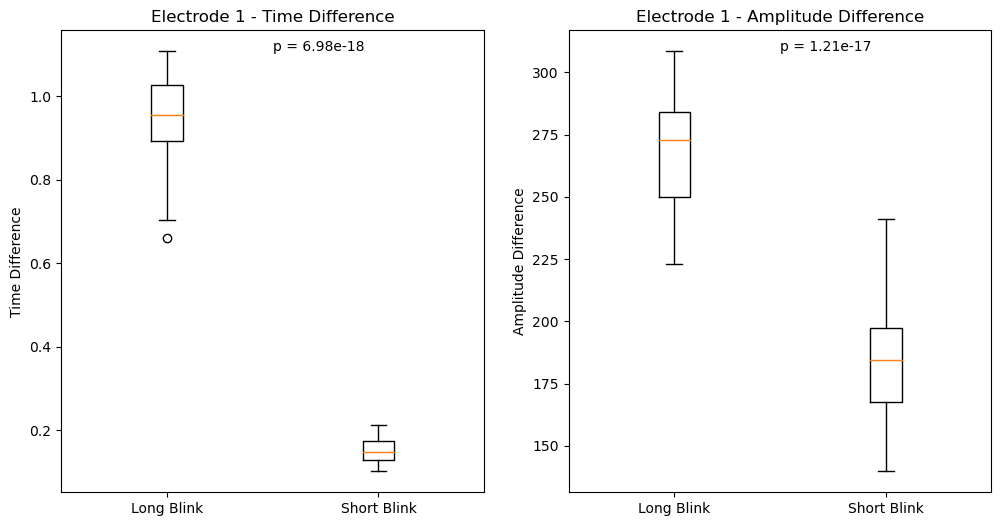

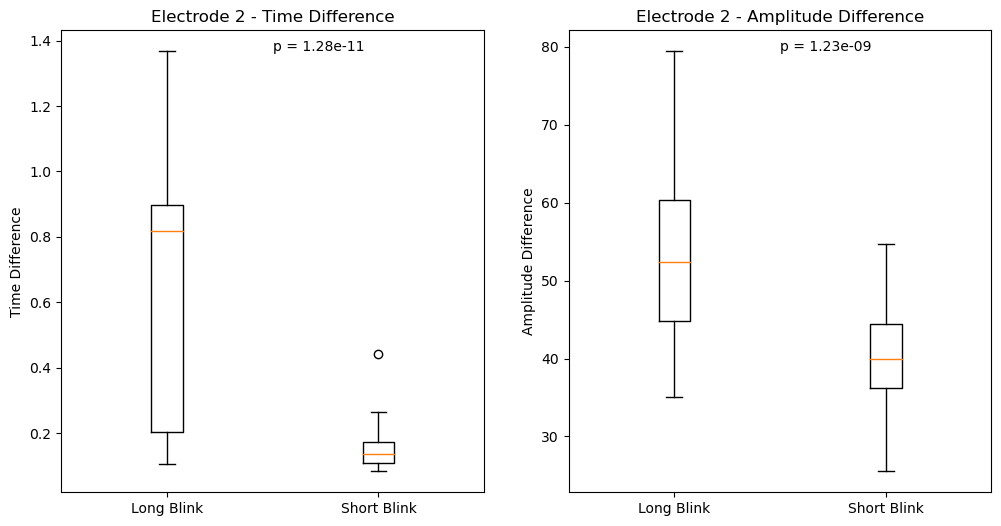

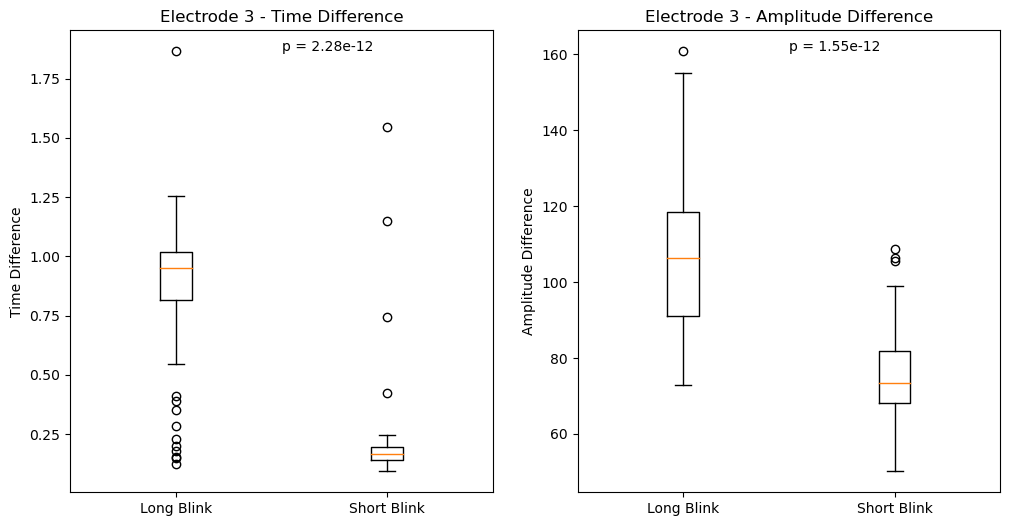

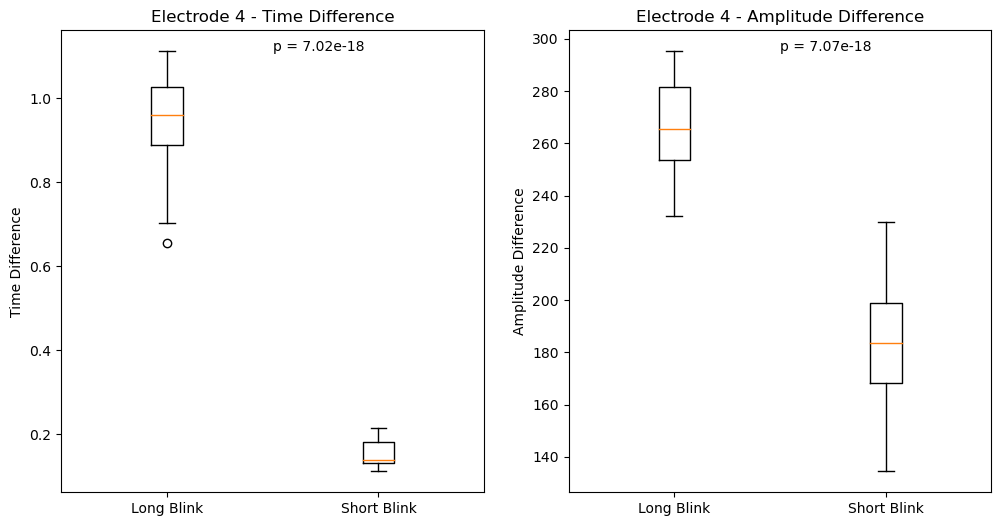

In [164]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Number of electrodes
num_electrodes = 4

# Assuming features are organized as [time_electrode1, amp_electrode1, time_electrode2, amp_electrode2, ...]
for i in range(num_electrodes):
    # Extract features for electrode i
    time_diff_long = features_long[:, i * 2]  # Time for long blink
    amp_diff_long = features_long[:, i * 2 + 1]  # Amplitude for long blink

    time_diff_short = features_short[:, i * 2]  # Time for short blink
    amp_diff_short = features_short[:, i * 2 + 1]  # Amplitude for short blink

    # Plot for time difference
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot([time_diff_long, time_diff_short], labels=['Long Blink', 'Short Blink'])
    plt.title(f'Electrode {i+1} - Time Difference')
    plt.ylabel('Time Difference')
    stat, p = mannwhitneyu(time_diff_long, time_diff_short)
    plt.text(1.5, max(np.max(time_diff_long), np.max(time_diff_short)), f'p = {p:.2e}')

    # Plot for amplitude difference
    plt.subplot(1, 2, 2)
    plt.boxplot([amp_diff_long, amp_diff_short], labels=['Long Blink', 'Short Blink'])
    plt.title(f'Electrode {i+1} - Amplitude Difference')
    plt.ylabel('Amplitude Difference')
    stat, p = mannwhitneyu(amp_diff_long, amp_diff_short)
    plt.text(1.5, max(np.max(amp_diff_long), np.max(amp_diff_short)), f'p = {p:.2e}')

    plt.show()


In [167]:
def remove_electrodes(data):
    # Assuming electrodes are in the order [electrode1_time, electrode1_amp, electrode2_time, electrode2_amp, ...]
    # Remove columns corresponding to electrodes 2 and 3
    return np.delete(data, [2, 3, 4, 5], axis=1)

filtered_features_long = remove_electrodes(features_long_blink)
filtered_features_short = remove_electrodes(features_short_blink)


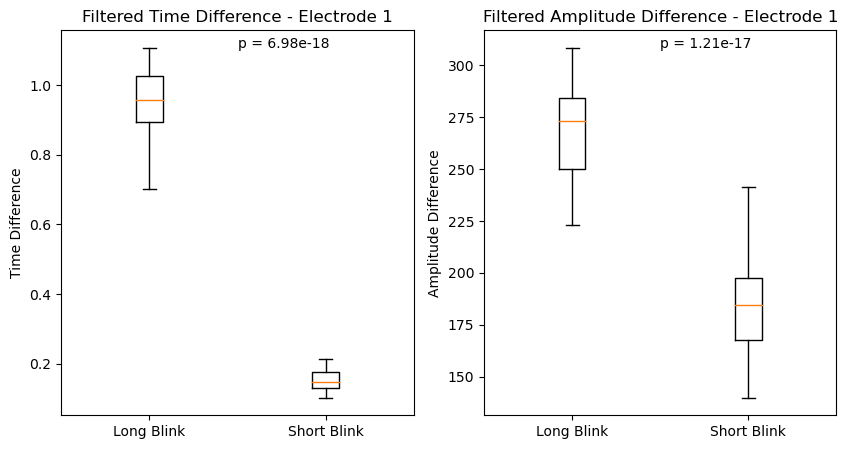

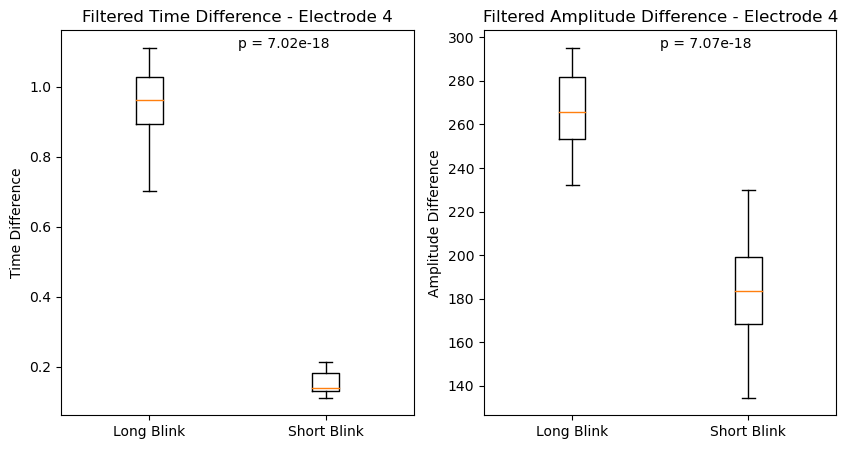

In [174]:
def plot_filtered_data(features_long, features_short, time_index, amp_index, electrode_label):
    plt.figure(figsize=(10, 5))

    # Remove outliers and extract data for plotting
    data_long_time = remove_outliers(features_long[:, time_index])
    data_short_time = remove_outliers(features_short[:, time_index])
    data_long_amp = remove_outliers(features_long[:, amp_index])
    data_short_amp = remove_outliers(features_short[:, amp_index])

    # Box plot for Time Difference
    plt.subplot(1, 2, 1)
    plt.boxplot([data_long_time, data_short_time], labels=['Long Blink', 'Short Blink'])
    plt.title(f'Filtered Time Difference - Electrode {electrode_label}')
    plt.ylabel('Time Difference')
    stat, p_value = mannwhitneyu(data_long_time, data_short_time)
    plt.text(1.5, max(np.max(data_long_time), np.max(data_short_time)), f'p = {p_value:.2e}')

    # Box plot for Amplitude Difference
    plt.subplot(1, 2, 2)
    plt.boxplot([data_long_amp, data_short_amp], labels=['Long Blink', 'Short Blink'])
    plt.title(f'Filtered Amplitude Difference - Electrode {electrode_label}')
    plt.ylabel('Amplitude Difference')
    stat, p_value = mannwhitneyu(data_long_amp, data_short_amp)
    plt.text(1.5, max(np.max(data_long_amp), np.max(data_short_amp)), f'p = {p_value:.2e}')

    plt.show()

# Plotting for Electrode 1 and Electrode 4
# Assuming the first two columns are for Electrode 1 (time and amplitude) and the next two for Electrode 4
plot_filtered_data(filtered_features_long, filtered_features_short, 0, 1, 1)  # Electrode 1
plot_filtered_data(filtered_features_long, filtered_features_short, 2, 3, 4)  # Electrode 4


In [185]:


# Define column names
column_names = ['Electrode 1 Time Difference', 'Electrode 1 Amplitude Difference', 
                'Electrode 4 Time Difference', 'Electrode 4 Amplitude Difference']

# Create DataFrame for filtered long blink features
df_long = pd.DataFrame(filtered_features_long, columns=column_names)

# Create DataFrame for filtered short blink features
df_short = pd.DataFrame(filtered_features_short, columns=column_names)



In [181]:
# Add 'label' column to df_long, filled with 1
df_long['Label'] = 1

# Add 'label' column to df_short, filled with 0
df_short['Label'] = 0


In [184]:
# Combine df_long and df_short into a single DataFrame
combined_df = pd.concat([df_long, df_short], ignore_index=True)

In [193]:
from sklearn.model_selection import train_test_split

# Assign features to X and the label to Y
X = combined_df.drop('Label', axis=1)
Y = combined_df['Label']

# First split: Separate out the training data (70%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)



# Print the sizes of each dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 70
Test set size: 30
Validation set size: 15


In [194]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [195]:
# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, Y_train)

# Predict on the test set
Y_pred_nb = nb_classifier.predict(X_test)

# Evaluate the Naive Bayes classifier
accuracy_nb = accuracy_score(Y_test, Y_pred_nb)
print("Naive Bayes Classifier:")
print("Accuracy:", accuracy_nb)
print(classification_report(Y_test, Y_pred_nb))



Naive Bayes Classifier:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [198]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [203]:
def plot_roc_curve(model, X_test, Y_test, model_name):
    # Predict probabilities
    probabilities = model.predict_proba(X_test)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(Y_test, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal


In [204]:
def plot_confusion_matrix(Y_test, Y_pred, model_name):
    cm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


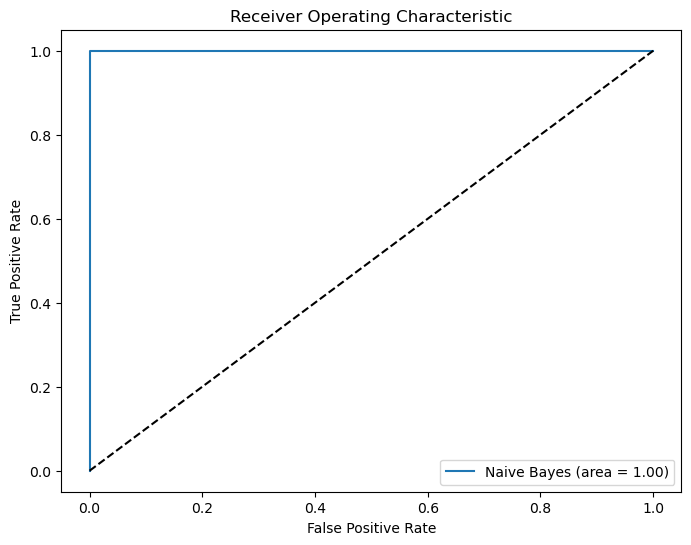

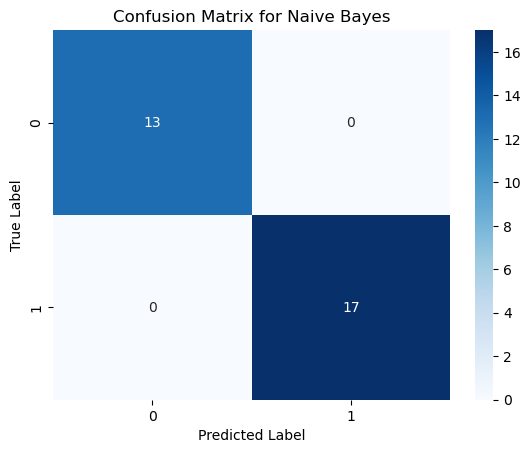

In [205]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plot_roc_curve(nb_classifier, X_test, Y_test, 'Naive Bayes')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Plot Confusion Matrices
plot_confusion_matrix(Y_test, Y_pred_nb, 'Naive Bayes')


All 10 Cross-Validation Scores:
[1. 1. 1. 1. 1.]

Mean CV Score: 1.0


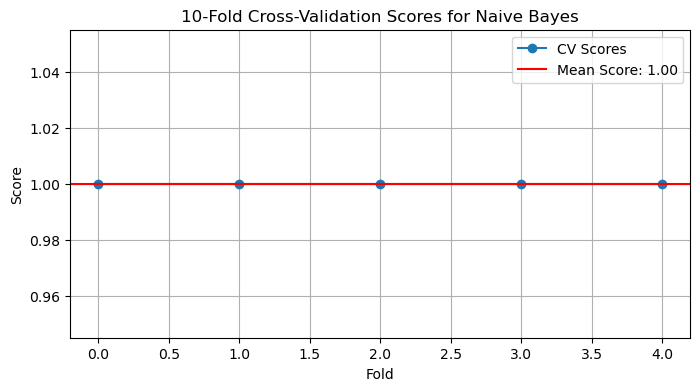

In [230]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Perform 10-fold cross-validation
cv_scores = cross_val_score(nb_model, X, Y, cv=5)  # 10-fold cross-validation

# Print all 10 CV scores
print("All 10 Cross-Validation Scores:")
print(cv_scores)

# Calculate and print the mean CV score
mean_cv_score = np.mean(cv_scores)
print("\nMean CV Score:", mean_cv_score)

# Plotting the CV scores
plt.figure(figsize=(8, 4))
plt.plot(cv_scores, label='CV Scores', marker='o')
plt.axhline(y=mean_cv_score, color='r', linestyle='-', label=f'Mean Score: {mean_cv_score:.2f}')
plt.title('10-Fold Cross-Validation Scores for Naive Bayes')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


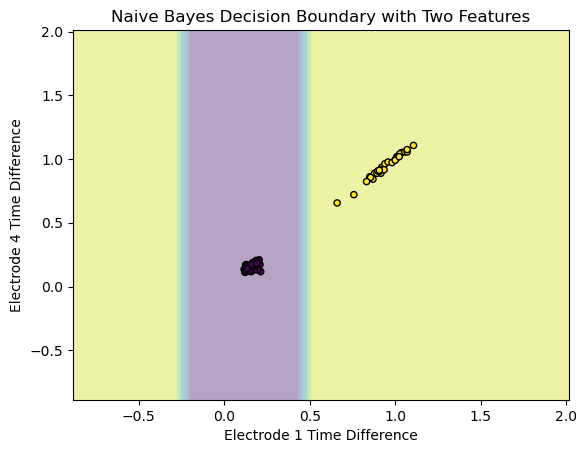

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


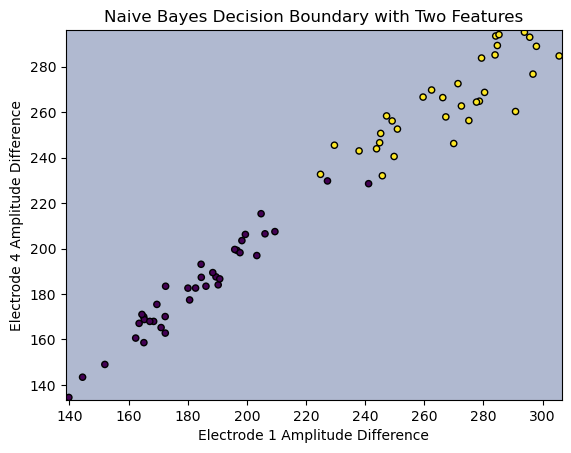

In [227]:


# Assuming you want to visualize the first two features
feature_1 = X_train.iloc[:, 0].name
feature_2 = X_train.iloc[:, 2].name

# Calculate mean/median for the other two features
feature_3_mean = X_train.iloc[:, 0].mean()
feature_4_mean = X_train.iloc[:, 2].mean()

# Create a meshgrid for visualization
x_min, x_max = X_train[feature_1].min() - 1, X_train[feature_1].max() + 1
y_min, y_max = X_train[feature_2].min() - 1, X_train[feature_2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict class for each point in the meshgrid
Z = nb_classifier.predict(np.c_[xx.ravel(), yy.ravel(), 
                                np.full(xx.ravel().shape, feature_3_mean), 
                                np.full(yy.ravel().shape, feature_4_mean)])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train[feature_1], X_train[feature_2], c=Y_train, s=20, edgecolor='k')
plt.title('Naive Bayes Decision Boundary with Two Features')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.show()




# Assuming you want to visualize the first two features
feature_1 = X_train.iloc[:, 1].name
feature_2 = X_train.iloc[:, 3].name

# Calculate mean/median for the other two features
feature_3_mean = X_train.iloc[:, 1].mean()
feature_4_mean = X_train.iloc[:, 3].mean()

# Create a meshgrid for visualization
x_min, x_max = X_train[feature_1].min() - 1, X_train[feature_1].max() + 1
y_min, y_max = X_train[feature_2].min() - 1, X_train[feature_2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict class for each point in the meshgrid
Z = nb_classifier.predict(np.c_[xx.ravel(), yy.ravel(), 
                                np.full(xx.ravel().shape, feature_3_mean), 
                                np.full(yy.ravel().shape, feature_4_mean)])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train[feature_1], X_train[feature_2], c=Y_train, s=20, edgecolor='k')
plt.title('Naive Bayes Decision Boundary with Two Features')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.show()


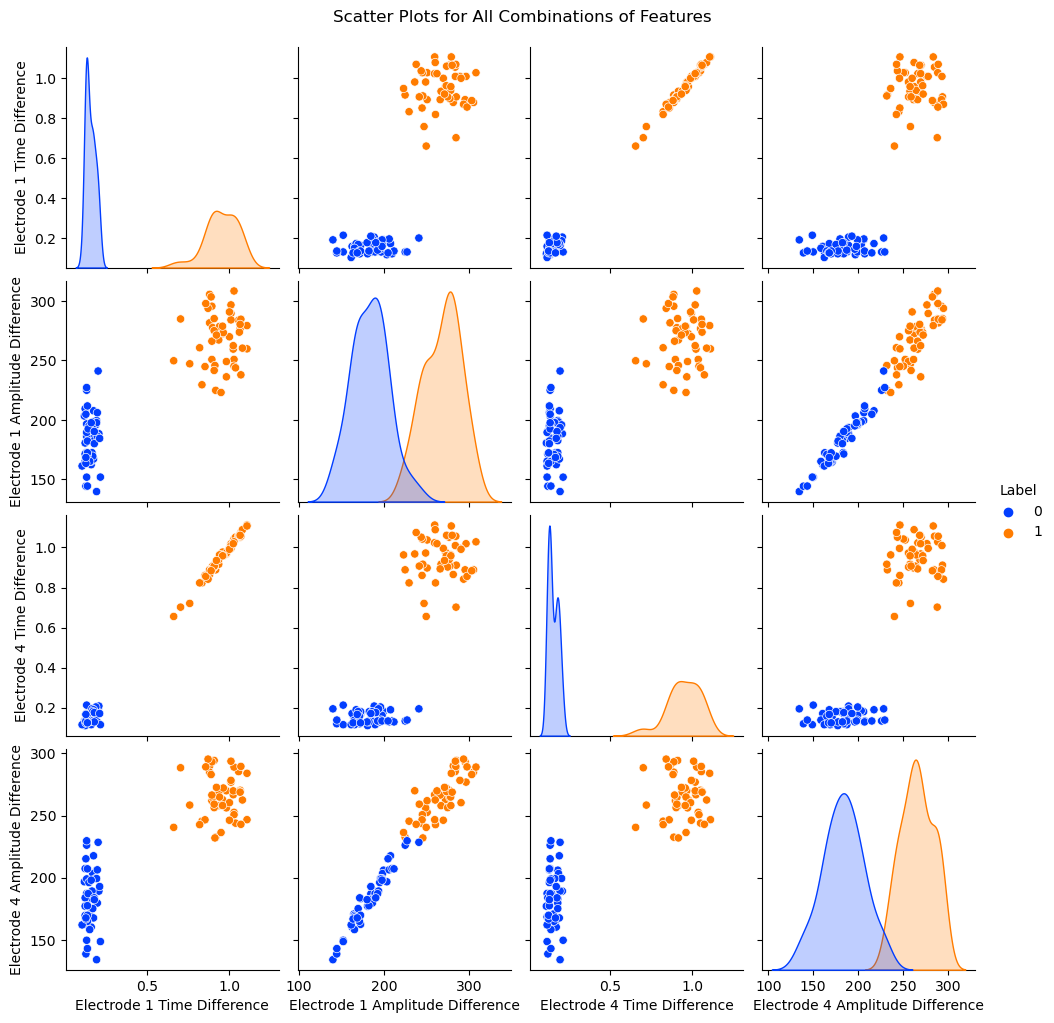

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(combined_df, vars=['Electrode 1 Time Difference', 'Electrode 1 Amplitude Difference', 'Electrode 4 Time Difference', 'Electrode 4 Amplitude Difference'], hue='Label', palette='bright')
plt.suptitle('Scatter Plots for All Combinations of Features', y=1.02)  # Adjust y for title space
plt.show()


In [ ]:
def preprocess_and_predict(new_data, classifier, fs=215, lowcut=1.0, highcut=30.0, session_length=510):
    """
    Process the unseen data and predict using the trained classifier.
    
    :param new_data: Raw data in the same format as the training data.
    :param classifier: Trained Naive Bayes classifier.
    :param fs: Sampling frequency.
    :param lowcut: Low cut frequency for bandpass filter.
    :param highcut: High cut frequency for bandpass filter.
    :param session_length: Length of each session in the data.
    :return: Predictions for the new data.
    """
    # Load and process the new data
    processed_data = process_data(new_data, fs, lowcut, highcut)

    # Extract features from the processed data
    features = extract_features(processed_data, session_length, fs)

    # Make predictions using the classifier
    predictions = classifier.predict(features)

    return predictions

# Example usage:
# new_data = load_data('path_to_new_data.csv')
# predictions = preprocess_and_predict(new_data, nb_classifier)
